In [1]:
artifacts_path = '/home/bit/storage/'

# Data

## 🔢 Data ingestion

In [2]:
import pandas as pd
from sklearn.datasets import load_iris

In [3]:
iris_bunch = load_iris(as_frame=True)
index_to_class_map = iris_bunch.target_names
index_to_class_map

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
iris_df = iris_bunch.frame
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## ✂️ Data splitting

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
iris_df.target.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [7]:
# Split dataset
test_size = 0.2
train_df, val_df = train_test_split(iris_df, stratify=iris_df.target, test_size=test_size, random_state=1234)

In [8]:
train_df.target.value_counts()

target
2    40
1    40
0    40
Name: count, dtype: int64

In [9]:
val_df.target.value_counts() * int((1-test_size) / test_size)

target
2    40
0    40
1    40
Name: count, dtype: int64

## 🔍 Exploratory Data Analysis (EDA)

In [10]:
import matplotlib.pyplot as plt

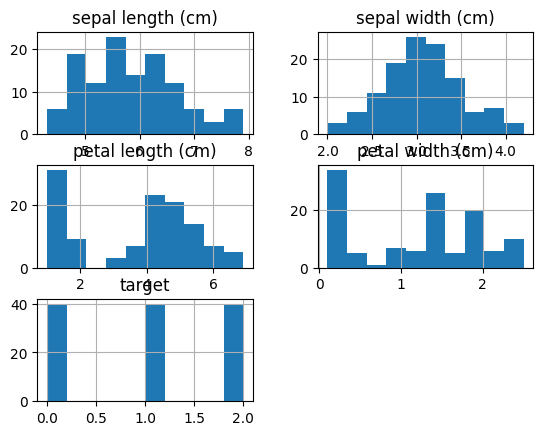

In [11]:
train_df.hist();

<Figure size 1000x600 with 0 Axes>

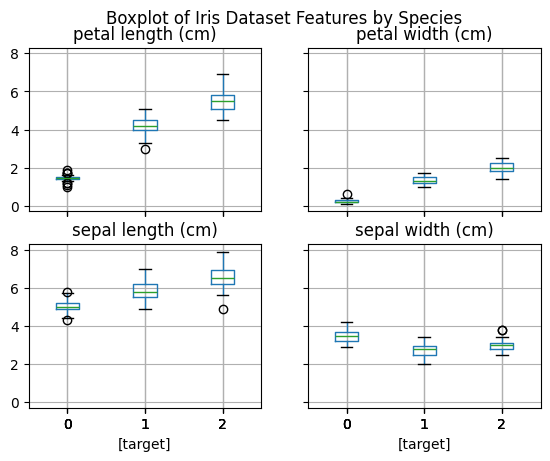

In [12]:
plt.figure(figsize=(10, 6));
train_df.boxplot(by='target');
plt.suptitle("Boxplot of Iris Dataset Features by Species");
plt.show();
# Good signal in the features to build a predictive model

## ✨ Data Preprocessing

In [13]:
# Our Case no need for prepocessing but generally good to have a preprocess function that can be applied on train and prediction data
def preprocess(data):
    #data = preprocess_step1(data)
    #data = preprocess_step2(data)
    
    return dict(X=data.drop(columns=['target']).values, targets=data['target'].values)
# Try to modularize the preporcess function into steps 
# functions might look like cleaning, tokenizing, imputing, label encoding

# Training

In [14]:
import os
import random
import sklearn
import numpy as np

In [15]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

## 🤖 Model

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
import pickle

In [17]:
model = RandomForestClassifier()

In [18]:
train_data = preprocess(train_df)
test_data = preprocess(val_df)

## 🚂 Training

In [19]:
model.fit(train_data['X'], train_data['targets'])

RandomForestClassifier()

In [20]:
with open(artifacts_path+'random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

### Evaluation

In [21]:
class SklearnPredictor:
    def __init__(self, model):
        self.model = model
        
    def __call__(self, data):
        return self.model.predict(data)

    def predict_prob(self, data):
        return self.model.predict_proba(data)

    @classmethod
    def from_checkpoint(cls, checkpoint):
        with open(checkpoint, 'rb') as file:
            model = pickle.load(file)
        return cls(model=model)
        
        

In [22]:
with open(artifacts_path+'random_forest_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [23]:
test_data = preprocess(val_df)

In [24]:
y_pred = model.predict(test_data['X'])

In [25]:
metrics = precision_recall_fscore_support(test_data['targets'], y_pred, average="weighted")
{"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

{'precision': 0.9333333333333333,
 'recall': 0.9333333333333333,
 'f1': 0.9333333333333333}

In [26]:
def evaluate(predictor, data):
    data = preprocess(data)
    y_true = data['targets']
    y_pred = predictor(data['X'])
    metrics = precision_recall_fscore_support(test_data['targets'], y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    return performance
    
    

In [27]:
predictor = SklearnPredictor.from_checkpoint(artifacts_path+'random_forest_model.pkl')

In [28]:
evaluate(predictor, val_df)

{'precision': 0.9333333333333333,
 'recall': 0.9333333333333333,
 'f1': 0.9333333333333333}

### Inference

In [29]:
def format_prob(prob, index_to_class):
    d = {}
    for i, item in enumerate(prob):
        d[index_to_class_map[i]] = item
    return d

def predict_proba(ds, predictor):
    ds = preprocess(ds)
    y_prob = predictor.predict_prob(ds['X'])
    results = []
    for i, prob in enumerate(y_prob):
        tag = index_to_class_map[prob.argmax()]
        results.append({"prediction": tag, "probabilities": format_prob(prob, index_to_class_map)})
    return results

In [30]:
sample_ds = pd.DataFrame({"sepal length (cm)": [2.0], "sepal width (cm)":[1.0], "petal length (cm)":[2.0], "petal width (cm)":[6.0], "target":[0]})

In [31]:
predict_proba(sample_ds, predictor)

[{'prediction': 'setosa',
  'probabilities': {'setosa': 0.45, 'versicolor': 0.13, 'virginica': 0.42}}]

# 🧪 Experiment tracking

In [32]:
import mlflow
from pathlib import Path
import mlflow.sklearn
import time

### Wraping training code into a function and adding mlflow logging


In [46]:
def train_mlflow(ds, experiment_name, **kwrgs):
    mlflow.set_experiment(experiment_name)
    n_estimators = kwrgs.get('n_estimators', 100)
    max_depth = kwrgs.get('max_depth', None)
    min_samples_split = kwrgs.get('min_samples_split', 2)

    mlflow.end_run() # figure out this weird bug 
    with mlflow.start_run():
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("min_samples_split", min_samples_split)
        train_data = preprocess(ds)
        
        model = RandomForestClassifier(n_estimators=n_estimators, 
                                       max_depth=max_depth,
                                       min_samples_split=min_samples_split)
        model.fit(train_data['X'], train_data['targets'])
        y_preds = model.predict(train_data['X'])
        metrics = precision_recall_fscore_support(train_data['targets'], y_preds, average="weighted")
        print(metrics[0])
        print(type(metrics[0]))
        mlflow.log_metric('precision', metrics[0])
        mlflow.log_metric('recall', metrics[1])
        mlflow.log_metric('f1', metrics[2])

        mlflow.sklearn.log_model(model, "random_forest_model")
        
    

In [47]:
# Config Mlflow
MODEL_REGISTRY = Path(f"{artifacts_path}/mlflow")
Path(MODEL_REGISTRY).mkdir(parents=True, exist_ok=True)
MLFLOW_TRACKING_URI = "file://" + str(MODEL_REGISTRY.absolute()) # using a local server for tracking can set up aws s3 instance too
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(mlflow.get_tracking_uri())

file:///home/bit/storage/mlflow


In [48]:
experiment_name = "iris_experiment"
n_estimators = int(input('Enter n_estimators:'))
max_depth = int(input('Enter max_depth:'))
min_samples_split = int(input('Enter min_samples_splits:'))
train_mlflow(train_df, experiment_name, max_depth=max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split)


Enter n_estimators: 100
Enter max_depth: 8
Enter min_samples_splits: 2


1.0
<class 'numpy.float64'>


In [55]:
from urllib.parse import urlparse

In [78]:
run_id = 'b67cd1a01ce24973a5014bc24c9a5ea2'
artifact_dir = urlparse(mlflow.get_run(run_id).info.artifact_uri).path
checkpoint = str(Path(f"{artifact_dir}/random_forest_model/model.pkl").absolute())

In [76]:
predictor = SklearnPredictor.from_checkpoint(checkpoint)
evaluate(predictor, val_df)

{'precision': 0.9333333333333333,
 'recall': 0.9333333333333333,
 'f1': 0.9333333333333333}

### Setup Mlflow Remote tracking on AWS

In [77]:
## refer Mlflow documentation for this do it later

# 🚀 Serving 